In [1]:
from aux_functions import *

# # clip video
# clip_video('Dataset/video/AOrotation_1.mp4', 'Dataset/neo_videos/AOrotation_1.mp4', 0, 10)
# clip_video('Dataset/video/AOrotation_2.mp4', 'Dataset/neo_videos/AOrotation_2.mp4', 0, 10)
# clip_video('Dataset/video/AOrotation_3.mp4', 'Dataset/neo_videos/AOrotation_3.mp4', 0, 10)
# clip_video('Dataset/video/video_floor_6.avi', 'Dataset/neo_videos/video_floor_6.avi', 0, 10)

In [ ]:
# extract frames
extract_frames('Dataset/neo_videos/AOrotation_1.mp4', 'Dataset/neo_images/',4, 0)
extract_frames('Dataset/neo_videos/AOrotation_2.mp4', 'Dataset/neo_images/',4, 25)
extract_frames('Dataset/neo_videos/AOrotation_3.mp4', 'Dataset/neo_images/',4, 50)
extract_frames('Dataset/neo_videos/video_floor_6.mp4', 'Dataset/neo_images/',4, 75)

In [ ]:
import os
import json
import numpy as np
from pycocotools import mask
import cv2

def process_json_to_resized_mask(input_folder, output_folder, target_height=400, target_width=640):
    """
    批量将 JSON 文件解析为指定尺寸的 PNG 蒙版文件。

    参数:
        input_folder (str): 存放 JSON 文件的文件夹路径。
        output_folder (str): 输出 PNG 文件的文件夹路径。
        target_height (int): 输出蒙版的高度，默认 400。
        target_width (int): 输出蒙版的宽度，默认 640。
    """
    os.makedirs(output_folder, exist_ok=True)

    # 遍历输入文件夹中的所有 JSON 文件
    for json_file in os.listdir(input_folder):
        if json_file.endswith(".json"):
            json_path = os.path.join(input_folder, json_file)
            print(json_path)
            # 加载 JSON 文件
            with open(json_path, "r") as f:
                data = json.load(f)

            # 获取图像和标注信息
            image_info = data["image"]
            annotations = data.get("annotations", [])

            # 确认输入图像的原始尺寸
            original_height = image_info["height"]
            original_width = image_info["width"]

            if original_height != 640 or original_width != 640:
                print(f"Skipping {json_file}: unexpected image size ({original_width}x{original_height}).")
                continue

            # 创建空白蒙版
            mask_image = np.zeros((original_height, original_width), dtype=np.uint8)

            # 遍历标注信息，解码 RLE 并叠加到蒙版
            for ann in annotations:
                rle = {
                    "counts": ann["segmentation"]["counts"],
                    "size": ann["segmentation"]["size"],
                }
                binary_mask = mask.decode(rle)  # 解码 RLE
                mask_image = np.maximum(mask_image, binary_mask * 255)  # 叠加蒙版

            # 调整分辨率到目标大小
            resized_mask = cv2.resize(mask_image, (target_width, target_height), interpolation=cv2.INTER_NEAREST)

            # 生成输出文件路径
            output_path = os.path.join(output_folder, f"{os.path.splitext(json_file)[0]}.png")

            # 保存调整后的蒙版为 PNG 文件
            cv2.imwrite(output_path, resized_mask)
            # print(f"Saved resized mask to: {output_path}")
            print(output_path)

# 使用示例
input_folder = "Dataset/json/"  # 替换为存放 JSON 文件的文件夹路径
output_folder = "Dataset/neo_masks/"  # 替换为保存 PNG 文件的文件夹路径

process_json_to_resized_mask(input_folder, output_folder)


In [ ]:
import os
import subprocess

def convert_avi_to_mp4(input_file, output_file, frame_rate=10):
    """
    将 .avi 文件转换为 .mp4 格式，调整分辨率为 640x400，并设置帧率为 10 FPS。

    参数:
        input_file (str): 输入的 .avi 文件路径。
        output_file (str): 输出的 .mp4 文件路径。
        frame_rate (int): 输出视频的帧率，默认 10 FPS。
    """
    # 检查输入文件是否存在
    if not os.path.isfile(input_file):
        raise FileNotFoundError(f"Input file '{input_file}' not found.")
    
    # 构建 ffmpeg 命令
    command = [
        "ffmpeg",
        "-i", input_file,           # 输入文件
        "-vf", "scale=640:400",     # 调整分辨率
        "-r", str(frame_rate),      # 设置帧率
        "-c:v", "libx264",          # 使用 H.264 编码
        "-preset", "fast",          # 快速压缩
        "-c:a", "copy",             # 保持原始音频编码
        output_file                 # 输出文件
    ]
    
    # 执行命令
    try:
        subprocess.run(command, check=True)
        print(f"Conversion successful: '{output_file}'")
    except subprocess.CalledProcessError as e:
        print(f"Error during conversion: {e}")


# 输入 .avi 文件路径
input_avi = "Dataset/neo_videos/video_floor_6.avi"

# 输出 .mp4 文件路径
output_mp4 = "Dataset/neo_videos/video_floor_6.mp4"

# 调用转换函数
convert_avi_to_mp4(input_avi, output_mp4)


In [ ]:
import os

# 批量重命名文件
def batch_rename_files(folder_path, prefix):
    """
    批量重命名文件夹中的文件，添加指定前缀。

    参数:
        folder_path (str): 文件夹路径。
        prefix (str): 添加的前缀。
    """
    for count, filename in enumerate(os.listdir(folder_path)):
        src = os.path.join(folder_path, filename)
        # print(filename)
        cur_id = int(filename[3:5])
        dst = os.path.join(folder_path, f"{prefix}{cur_id:02d}{os.path.splitext(filename)[1]}")
        os.rename(src, dst)
        print(f"Renamed '{src}' to '{dst}'")

# 使用示例
folder_path = "Dataset/neo_masks/"  # 替换为目标文件夹路径
prefix = "000"  # 替换为所需前缀

batch_rename_files(folder_path, prefix)

In [ ]:
import numpy as np

def calculate_mean_and_variance(numbers):
    """
    计算输入数字列表的平均值和方差。

    参数:
        numbers (list): 数字列表。

    返回:
        tuple: 平均值和方差。
    """
    mean = np.mean(numbers)
    variance = np.var(numbers)

    print(f"Mean: {mean}, Variance: {variance}")

    return mean, variance

# 使用示例
set_1 = [40,50,40,60,55,55,50,60,55,35,40,50,50,45,55,55,55,50,40,45,50,50,50,55,55]
set_2 = [35,35,30,35,35,30,30,30,35,35,30,35,35,30,25,40,35,35,30,30,35,30,35,30,30]
set_3 = [25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25]
set_4 = [40,35,35,45,40,45,40,35,35,35,35,35,35,40,35,35,35,45,35,40,60,35,50,55,40]
set_total = [set_1[:], set_2[:], set_3[:], set_4[:]]

calculate_mean_and_variance(set_1)
calculate_mean_and_variance(set_2)
calculate_mean_and_variance(set_3)
calculate_mean_and_variance(set_4)
calculate_mean_and_variance(set_total)


In [ ]:
import cv2
import os

def batch_rotate_images(input_folder, output_folder, angle):
    """
    批量旋转文件夹中的所有图片，并将旋转后的图片保存到输出文件夹中。

    参数:
        input_folder (str): 输入图片文件夹路径。
        output_folder (str): 输出图片文件夹路径。
        angle (float): 旋转角度（顺时针方向）。
    """
    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(input_folder):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            img_path = os.path.join(input_folder, filename)
            img = cv2.imread(img_path)

            if img is None:
                print(f"Failed to load image: {img_path}")
                continue

            # 获取图像中心
            (h, w) = img.shape[:2]
            center = (w // 2, h // 2)

            # 计算旋转矩阵
            M = cv2.getRotationMatrix2D(center, angle, 1.0)

            # 执行旋转
            rotated = cv2.warpAffine(img, M, (w, h))

            # 生成输出文件路径
            output_path = os.path.join(output_folder, filename)

            # 保存旋转后的图片
            cv2.imwrite(output_path, rotated)
            print(f"Saved rotated image to: {output_path}")

# 使用示例
input_folder = "Dataset/task2/001_neo/"  # 替换为输入图片文件夹路径
output_folder = "Dataset/task2/001_neo_rotated/"  # 替换为输出图片文件夹路径
angle = 90  # 替换为所需旋转角度

batch_rotate_images(input_folder, output_folder, angle)


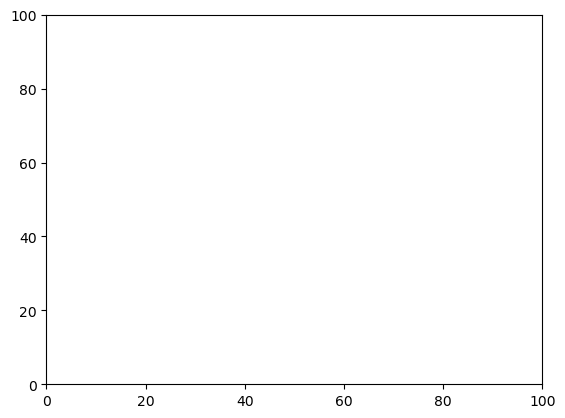

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation

# 示例2维坐标点
points = np.random.rand(10, 2) * 100  # 生成10个随机点

# 创建图形和坐标轴
fig, ax = plt.subplots()
sc = ax.scatter([], [])

# 设置坐标轴范围
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

# 动态更新函数
def update(frame):
    sc.set_offsets(points[:frame])
    return sc,

# 动态绘制
ani = FuncAnimation(fig, update, frames=len(points)+1, interval=500, blit=True)

plt.show()


In [8]:
from task2c import *

import cv2

# 打开两个摄像头
left_camera = cv2.VideoCapture('/dev/video2')  # 左摄像头
right_camera = cv2.VideoCapture('/dev/video4')  # 右摄像头

# 检查摄像头是否成功打开
if not left_camera.isOpened():
    print("无法打开左摄像头")
    exit()
if not right_camera.isOpened():
    print("无法打开右摄像头")
    exit()

while True:
    # 读取左右摄像头的帧
    ret_left, frame_left = left_camera.read()
    ret_right, frame_right = right_camera.read()

    if not ret_left or not ret_right:
        print("无法读取摄像头帧")
        break

    # 显示左右摄像头的图像
    cv2.imshow("Left Camera", frame_left)
    cv2.imshow("Right Camera", frame_right)

    # 按下 'q' 键退出
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# 释放摄像头资源并关闭窗口
left_camera.release()
right_camera.release()
cv2.destroyAllWindows()


In [ ]:
import re
import pkg_resources

# 读取文件
file_path = "your_script.py"  # 替换为你的文件路径
with open(file_path, "r") as f:
    lines = f.readlines()

# 匹配 import 和 from ... import 的正则
imported_modules = set()
pattern_import = re.compile(r"^\s*import\s+(\w+)")
pattern_from_import = re.compile(r"^\s*from\s+(\w+)\s+import")

for line in lines:
    match_import = pattern_import.match(line)
    match_from_import = pattern_from_import.match(line)
    if match_import:
        imported_modules.add(match_import.group(1))
    if match_from_import:
        imported_modules.add(match_from_import.group(1))

# 查询版本号
for module in imported_modules:
    try:
        version = pkg_resources.get_distribution(module).version
        print(f"{module}: {version}")
    except pkg_resources.DistributionNotFound:
        print(f"{module}: version not found (might be built-in or missing)")
